# Machine Learning - Handwritten Digits Classifier

This is a DataQuest guided machine learning project with the following goal of comparing the k-nearest neighbors algorithm to a MLP neural network model on the task of classifying images of hand-written digits.

The dataset being used is the [hand-written digits dataset](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) from UCI, which is bundled with Scikit-learn. It includes 1797 samples from the original dataset and their labels. 

Each sample in the set includes 64 features which describe the grayscale values for each pixel in the 8x8 image of a handwritten letter.

# Libraries

In [1]:
from sklearn.datasets import load_digits
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy import random
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Data

In [2]:
#Import Dataset from sklearn
image_dict = load_digits()

#print shape and possible labels
print(image_dict.data.shape)
print(image_dict.target_names)

#Load Dataframe
df = pd.DataFrame(image_dict.data)
labels = pd.Series(image_dict.target)
df['label'] = labels


(1797, 64)
[0 1 2 3 4 5 6 7 8 9]


# Example Images

Below are samples of hand-written digits from the dataset. I have set the random_state to 3 to highlight a few of the many nuances in the data;
1. Some zeros do not fully connect.
2. Ones could be a straight line or have a sarif.
3. Sixes, eights, and nines all have inconsistant loop sizes.
4. Sevens may or may not be crossed.
5. Nines sometimes look like the letter g with a curly line.


A clear issue in creating a classifier for this dataset is that the digits are non-linear. The model/algorithm must be adept at finding non-linear patterns in the data.

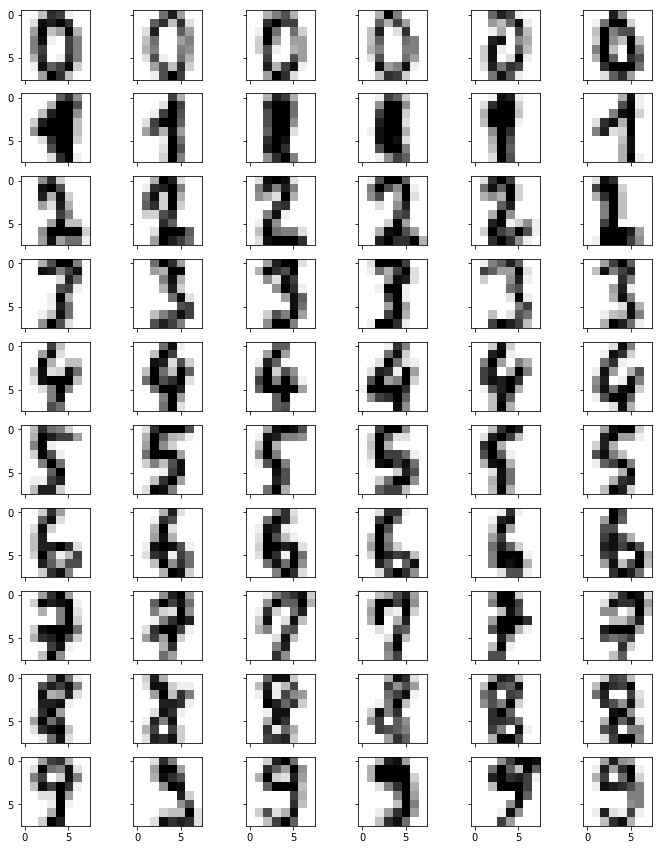

In [3]:
fig, axs = plt.subplots(nrows=10, ncols=6, 
                        sharex=True, sharey=True, 
                        figsize=(12, 15))
for nbr in image_dict.target_names:
    sample = df[df['label'] == nbr].sample(6, random_state=3)
    sample = sample.drop('label', axis=1)
    sample = sample.reset_index(drop=True)

    for i in range(6):
        image = sample.iloc[i,:]
        np_image = image.values
        np_image = np_image.reshape(8, 8)
        axs[nbr, i].imshow(np_image, cmap='gray_r')
        
plt.subplots_adjust(wspace=0.05, hspace=0.2)

# K-Nearest Neighbors Approach

The first algorithm that I'm testing will be KNN. This model has a chance at succeeding because it makes no assumptions about linearity and it is not trying to fit the data to a linear model. Instead, it will find the most similar cases to a test case in the training data and use their labels to infer the test case label.

My assumption is that this approach will work reasonably well with certain numbers, like zero, which are clearly different from the others, but struggle with numbers that have more similar neighbors, like 3, 8, and 9.

### Result

The KNN algorithm performed reasonably well, achieving a 98.6% accuracy rate. Looking at examples of errors that the classifier made, labels 4 and 8 were the most problematic. The 8s that were missed typically had their lower loop filled in and were mistaken for 1s. The 4s that were missed had lines that slanted to the left or tops that were nearly closed loops and were mistaken for 7s or 9s.

In [4]:
#training function
def train_test_knn(dataframe, n):
    data = dataframe.copy()
    
    #cross validator setup
    kf = KFold(n_splits=4, shuffle=True, random_state=1)
    errors = []
    
    for train_index, test_index in kf.split(df):
        #partition
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        
        #define features, label
        feature_index = list(data.columns)
        feature_index.remove('label')
        train_features = train[feature_index]
        train_label = train['label']
        test_features = test[feature_index]
        test_label = test['label']
        
        #fit model
        knn = KNeighborsClassifier(n_neighbors=n, algorithm='auto')
        knn.fit(train_features, train_label)
        
        #predict and measure error
        predictions = knn.predict(test_features)
        errors.append(accuracy_score(y_true=test_label, y_pred=predictions))

    return sum(errors) / len(errors)

def knn_example_errors(dataframe):
    data = dataframe.copy()
    data = data.sample(frac=1, random_state=1)
    last_row = int(data.shape[0] * .75)
    
    #partition
    train = data[:last_row].copy()
    test = data[last_row:].copy()

    #define features, label
    feature_index = list(data.columns)
    feature_index.remove('label')
    train_features = train[feature_index]
    train_label = train['label']
    test_features = test[feature_index]
    test_label = test['label']

    #fit model
    knn = KNeighborsClassifier(n_neighbors=3, algorithm='auto')
    knn.fit(train_features, train_label)

    #predict and measure error
    test['predictions'] = knn.predict(test_features)
    error_examples = test[~(test['predictions'] == test['label'])]
    
    return error_examples


In [5]:
#grid search k, print error rates for model.
for i in range(2, 8):
    print("k={}: {}%".format(i, round(train_test_knn(df, n=i), 3) * 100))

k=2: 98.1%
k=3: 98.6%
k=4: 98.5%
k=5: 98.3%
k=6: 98.1%
k=7: 98.2%


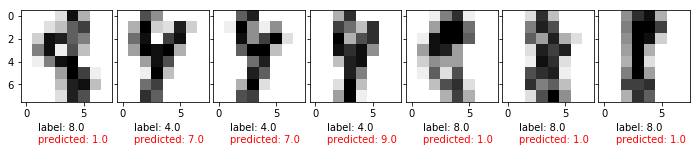

In [6]:
#Example errors
error_examples = knn_example_errors(df)
error_examples = error_examples.reset_index(drop=True)

#plot missed images
fig, axs = plt.subplots(nrows=1, ncols=7, 
                        sharex=True, sharey=True, 
                        figsize=(12, 4))
for i in range(error_examples.shape[0]):
    image = error_examples.iloc[i,:]
    label = image['label']
    prediction = image['predictions']
    image = image.drop(['label', 'predictions'])
    np_image = image.values
    np_image = np_image.reshape(8, 8)
    axs[i].imshow(np_image, cmap='gray_r')
    axs[i].text(x=1, y=10, s="label: {}".format(label))
    axs[i].text(x=1, y=11, s="predicted: {}".format(prediction), color='red')
        
plt.subplots_adjust(wspace=0.05)

# Neural Network Models

While the KNN model was fairly accurate, there is still room for improvement in both accuracy and efficiency. In terms of efficiency, an algorithm that creates a model representation may be an improvement as it does not require the set to be rescanned for each new test case. This would allow the model to be used on a much larger datasets and in real time more efficiently.

The next models that I am testing are Multi-layer Perception (MLP) neural networks with various parameters (neuron and layer counts). I will again be using KFolds cross-validation to help minimize overfitting. Additionally, I have added a printout of the test and train results for each fold so we can see where, if anywhere, overfitting is occuring.

#### Results

The neural network models that I tested did not quite reach the accuracy of the KNN algorithm. The best model, a single layer with 64 nodes, returned predictions with 98.1% accuracy.

#### Train and Test Function

In [7]:
def nn_train_test(dataframe, hidden_layer_sizes, alpha):
    data = dataframe.copy()
    
    #validator and error list
    kf = KFold(n_splits=8, random_state=1, shuffle=True)
    test_errors = []
    train_errors = []
    
    for train_index, test_index in kf.split(data):
        #partition
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        
        #define features, label
        feature_index = list(data.columns)
        feature_index.remove('label')
        train_features = train[feature_index]
        train_labels = train['label']
        test_features = test[feature_index]
        test_labels = test['label']
        
        #instantiate model and train
        clf = MLPClassifier(alpha=alpha, hidden_layer_sizes=hidden_layer_sizes, max_iter=10000, activation='relu')
        clf.fit(train_features, train_labels)
        
        #Predict on test and training sets
        test_predictions = clf.predict(test_features)
        train_predictions = clf.predict(train_features)
        
        #Measure test and training prediction errors
        test_errors.append(accuracy_score(test_labels, test_predictions))
        train_errors.append(accuracy_score(train_labels, train_predictions))
        
        #Track error examples
        #error_examples.append
    
    #return average errors
    avg_test_err = sum(test_errors) / len(test_errors)
    avg_train_err = sum(train_errors) / len(train_errors)
    
    return avg_train_err, avg_test_err


#### Single Hidden Layer Models

In [8]:
#hidden layer sizes grid
one_layer = [(8,), 
             (16,), 
             (32,), 
             (64,),
             (128,),
             (256,),
             (512,),
             (1028,)
            ]

#grid search and print error rates
for hls in one_layer:
    print(nn_train_test(df, hidden_layer_sizes=hls, alpha=.0004))

(0.994754789797295, 0.9426736111111111)
(1.0, 0.9632738095238095)
(1.0, 0.9688442460317461)
(1.0, 0.9693998015873015)
(1.0, 0.978298611111111)
(1.0, 0.9816344246031746)
(1.0, 0.9816369047619047)
(1.0, 0.9838591269841269)


#### Two Hidden Layer Models

In [9]:
#hidden layer sizes grid
one_layer = [(64, 64),
             (128, 128),
             (256, 256),
             (512, 512),
             (1024, 1024)
            ]

#grid search and print error rates
for hls in one_layer:
    print(nn_train_test(df, hidden_layer_sizes=hls, alpha=.0128))

(1.0, 0.9766369047619048)
(1.0, 0.9788640873015872)
(1.0, 0.9771850198412699)
(1.0, 0.9805233134920636)
(1.0, 0.9838640873015874)


#### Three Hidden Layer Models

In [10]:
#hidden layer sizes grid
one_layer = [(10, 10, 10), 
             (64, 64, 64),  
             (128, 128, 128),
             (256, 256, 256)
            ]

#grid search and print error rates
for hls in one_layer:
    print(nn_train_test(df, hidden_layer_sizes=hls, alpha=.0128))

(0.9997615009325627, 0.9326785714285716)
(1.0, 0.9727281746031746)
(1.0, 0.9799652777777778)
(1.0, 0.9833035714285715)
